Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Clean version](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/demos/demo11/demo11.ipynb)

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Modified in class](https://colab.research.google.com/drive/1SK47cU6k9u9iE8LmH5rtDVnz2eIlghDP?usp=sharing)

# Demo 11 - Spatial Visualization

In [1]:
# Basic dependencies
import matplotlib.pyplot as plt
import os

In [2]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Set the working directory
# # You will need to change this to your own folder on Google Drive
# os.chdir('/content/drive/MyDrive/Teaching/URSP688Y Spring 2024/demos/week11')

## GeoPandas

The simplest option

In [103]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [80]:
crs = 26918 # UTM18
affordable_housing = gpd.read_file('affordable_housing.geojson').to_crs(crs)
tracts = gpd.read_file('dc_tracts.geojson').to_crs(crs)
# Restrict to tract-level features, which have geoids 18 characters long
tracts = tracts[tracts.geoid.str.len() == 18]

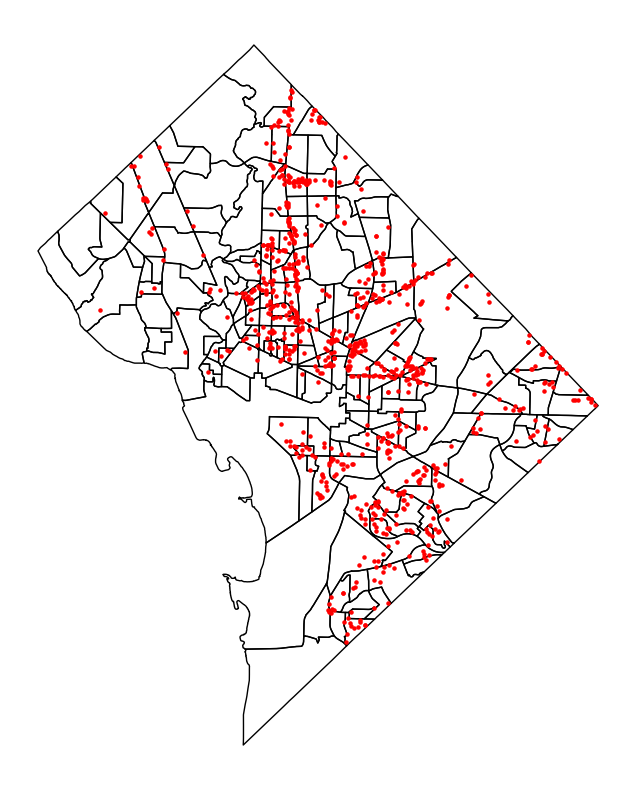

In [81]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, facecolor='none', edgecolor='k', zorder=0)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

In [82]:
affordable_housing = affordable_housing.sjoin(tracts[['geoid','geometry']])

In [83]:
tracts = tracts.set_index('geoid')

In [84]:
tracts = pd.concat([tracts, affordable_housing.groupby('geoid').agg({'TOTAL_AFFORDABLE_UNITS':'sum'})], axis=1)
tracts = tracts.fillna(0)

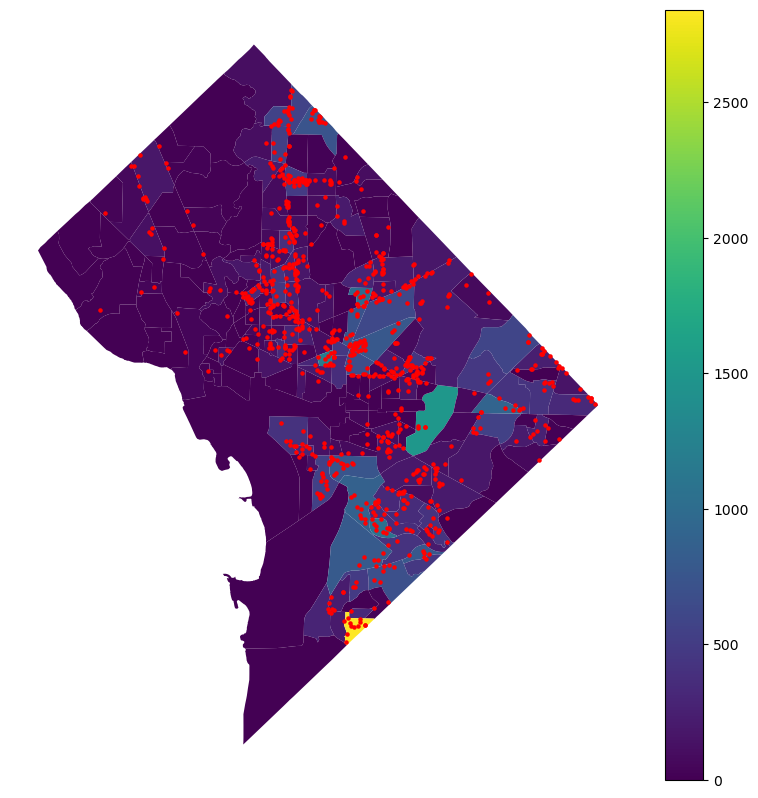

In [97]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, column='TOTAL_AFFORDABLE_UNITS', legend=True)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

In [101]:
tracts['affordable_units_per_pop'] = tracts['TOTAL_AFFORDABLE_UNITS'] / tracts['B01003001']

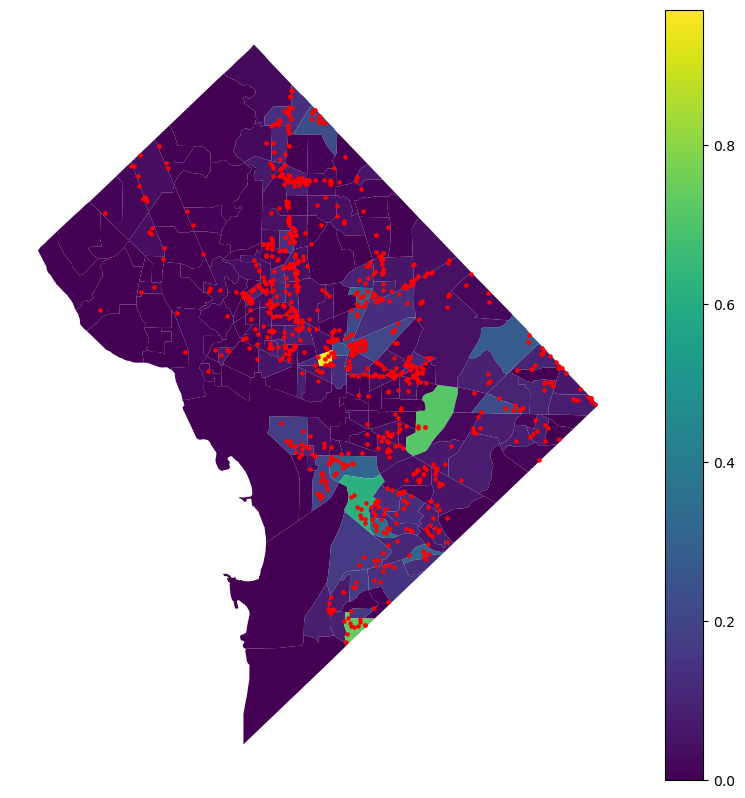

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, column='affordable_units_per_pop', legend=True)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, column='TOTAL_AFFORDABLE_UNITS', legend=True)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

In [ ]:
tract_points = tracts.copy()
tract_points['geometry'] = tract_points.centroid

def proportional_circles_radii(values, multiplier=1):
    return np.sqrt(values / 3.14) * multiplier

fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, facecolor='none', edgecolor='k', zorder=0, linewidth=0.5)

tract_points.buffer(proportional_circles_radii(tract_points['TOTAL_AFFORDABLE_UNITS'], 25)).plot(ax=ax, zorder=1, facecolor='#1300bf50', edgecolor='darkblue', linewidth=0.5)
# affordable_housing.plot(ax=ax, markersize=1, color='darkblue', zorder=2)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

In [133]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 13.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.1 MB/s eta 0:00:00


In [134]:
import contextily as cx

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


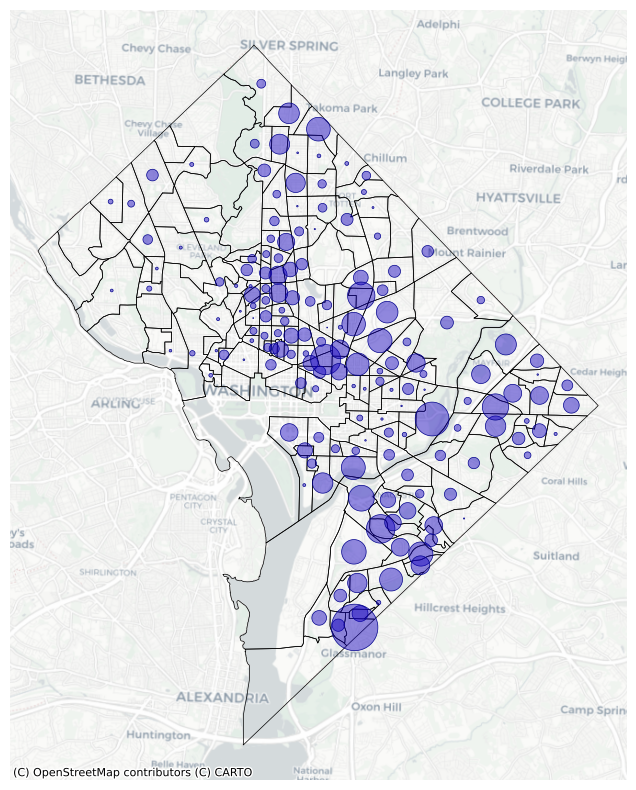

In [151]:
tract_points = tracts.copy()
tract_points['geometry'] = tract_points.centroid

def proportional_circles_radii(values, multiplier=1):
    return np.sqrt(values / 3.14) * multiplier

fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, facecolor='none', edgecolor='k', zorder=1, linewidth=0.5)

tract_points.buffer(proportional_circles_radii(tract_points['TOTAL_AFFORDABLE_UNITS'], 25)).plot(ax=ax, facecolor='#1300bf75', edgecolor='darkblue', linewidth=0.5, zorder=2)
ax.axis('off')

# Base map with labels embedded
cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Positron, zorder=0)

# Base map with labels overlaid
# cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.PositronNoLabels, zorder=0)
# cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.PositronOnlyLabels, zorder=3)

plt.savefig('large_scale_map.eps')

plt.show()

## Folium

Interactive web-style maps with on [Leaflet.js](https://leafletjs.com/reference)

In [6]:
# !pip install folium

In [7]:
import folium

In [10]:
affordable_housing = gpd.read_file('affordable_housing.geojson')
tracts = gpd.read_file('dc_tracts.geojson')

# Project into lat and long (WGS84)
affordable_housing = affordable_housing.to_crs(4326)
tracts = tracts.to_crs(4326)

# Drop column with timestamps because they interfere with Folium
affordable_housing = affordable_housing.drop(columns=['GIS_LAST_MOD_DTTM'])

# Identify map center
lon_min, lat_min, lon_max, lat_max = tracts.total_bounds
lon_center = (lon_max + lon_min) / 2
lat_center = (lat_max + lat_min) / 2

# Initiate map
map = folium.Map(location=(lat_center, lon_center), zoom_start=12)
# map = folium.Map(location=(lat_center, lon_center), zoom_start=12, tiles="Cartodb Positron")

# Add tracts
tract_style = {
    'weight': 1,
    'color': 'black',
    'fillColor': '#00000000',
    'fillOpacity': 1,
    }
folium.GeoJson(data=tracts.to_json(), style_function=lambda x: tract_style).add_to(map)

# Add affordable housing points
circle_marker = folium.CircleMarker(radius = 4, weight = 1, color='white', fillColor = 'darkblue', fill_opacity=1)
affordable_housing_points = folium.GeoJson(affordable_housing.to_json(), marker=circle_marker)
folium.features.GeoJsonPopup(fields=['PROJECT_NAME','TOTAL_AFFORDABLE_UNITS'], labels=True).add_to(affordable_housing_points)
affordable_housing_points.add_to(map)

map

## CartoPy

Good for smaller-scale maps with sophisticated projections and built-in reference layers

In [ ]:
# !pip install cartopy

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as creature

In [ ]:
# Define highlight city
highlight_city = 'Washington,  D.C.'
# highlight_city = 'Chicago'

# Load city points
pop_places = gpd.read_file('ne_10m_populated_places_simple.zip')

# Define map center and extents around the highlight city
lon_center = pop_places[pop_places['name'] == highlight_city].geometry.x.iloc[0]
lat_center = pop_places[pop_places['name'] == highlight_city].geometry.y.iloc[0]
extent = 50
lon_min = lon_center + (extent / 2)
lon_max = lon_center - (extent / 2)
lat_min = lat_center - (extent / 2)
lat_max = lat_center + (extent / 2)

# Define projection centered on highlight city
crs = ccrs.AzimuthalEquidistant(central_longitude=dc_center_lon, central_latitude=dc_center_lat)

# Project cities into axis coordinate system
pop_places = pop_places.to_crs(crs.proj4_init)

# Constrain to cities only one rank lower than the highlight
rank = pop_places[pop_places['name'] == highlight_city].scalerank.iloc[0] + 1
pop_places = pop_places[pop_places.scalerank <= rank]

# Initiate figure
fig = plt.figure(figsize=(15, 10))

# Initiate axis with defined projection
ax = plt.subplot(1, 1, 1, projection=crs)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add base features
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='blue', linestyle='--', zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.COASTLINE, zorder=2)
ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=3)
ax.add_feature(cfeature.STATES, zorder=4)
ax.add_feature(cfeature.RIVERS, zorder=5)

# Add city points
pop_places.plot(ax=ax, markersize=5, color='k', zorder=1)
pop_places[pop_places['name'] == highlight_city].plot(ax=ax, markersize=50, color='r', zorder=6)

# Label cities
def annotate(record):
    if record['name'] == highlight_city:
        ax.annotate(record['name'], weight='bold', size=14, color='red', xy=record.geometry.coords[0], xytext=(3, 3), textcoords='offset points', clip_on=True)
    else:
        ax.annotate(record['name'], xy=record.geometry.coords[0], xytext=(3, 3), textcoords='offset points', clip_on=True)
pop_places.apply(annotate, axis=1)

plt.savefig('small_scale_map.eps', format='eps')

plt.show()